In [1]:
import os
import sys
import pickle

import torch
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# turn off dark mode
plt.style.use('default')

from tqdm import tqdm

In [2]:
class StockReturnsDataset(Dataset):
    def __init__(self, dataset: pd.DataFrame, apply_augment=True) -> None:
        super().__init__()
        # preprocess dataset
        self.returns = dataset.pct_change(1, fill_method="ffill")[1:]
        self.apply_augment = apply_augment
        # self.bernoulli_dist = torch.distributions.Bernoulli(0.95)
        
    def __len__(self):
        return len(self.returns) - 1

    def __getitem__(self, index):
        i, j = self.returns.index[index], self.returns.index[index + 1]
        x = self.returns.loc[i].values
        y = self.returns.loc[j].values

        x = torch.from_numpy(x).float()
        y = torch.from_numpy(y).float()

        if self.apply_augment:
            # add random noise
            x = x + (torch.rand_like(x) - 0.5) / 1000

            # random zero stock return
            m = (torch.rand_like(x) < 0.98)
            x = x * m
        return x, y

In [3]:
with open("train_dataset.pkl", "rb") as f:
    train_df = pickle.load(f)

train_df = train_df['Adj Close'] # market close value
train_df = train_df.fillna(method='ffill') # attempt to fill nan values
train_df = train_df.dropna(axis=1) # remove stocks with nan values that couldn't be filled

assert pd.isna(train_df).any().sum() == 0

stocks = train_df.columns # stocks to keep without nan values

with open("test_dataset.pkl", "rb") as f:
    test_df = pickle.load(f)

test_df = test_df['Adj Close']
test_df = test_df[stocks]

assert pd.isna(test_df).any().sum() == 0

In [4]:
train_dataset = StockReturnsDataset(train_df)
test_dataset = StockReturnsDataset(test_df)

print("train dataset length", len(train_dataset))
print("test dataset length", len(test_dataset))

train_loader = DataLoader(train_dataset, batch_size=12, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=12, shuffle=False)

x,y = next(iter(train_loader))
x.shape, y.shape

train dataset length 1234
test dataset length 19


(torch.Size([12, 493]), torch.Size([12, 493]))

In [5]:
x.min(), x.mean(), x.max(), x.std()

(tensor(-0.1784), tensor(0.0030), tensor(0.1655), tensor(0.0205))

In [6]:
class RRNet(torch.nn.Module):
    def __init__(self, dim, depth, activation=torch.nn.ReLU, dropout=0.3, batch_norm=True, skip_connection=True) -> None:
        super().__init__()
        self.dim = dim
        self.depth = depth
        self.activation = activation
        self.dropout = dropout
        self.use_batch_norm = batch_norm
        self.use_skip_connection = skip_connection

        _mlps = []
        for _ in range(depth):
            _mlps.append(torch.nn.Linear(dim, dim))
            _mlps.append(activation())
            if self.use_batch_norm:
                _mlps.append(torch.nn.BatchNorm1d(self.dim))
            _mlps.append(torch.nn.Dropout(dropout))
        _mlps.append(torch.nn.Linear(dim, dim)) # last layer without activation
        self.mlps = torch.nn.Sequential(*_mlps)

    def forward(self, x):
        # forward pass with skip connection
        # return x + self.mlps(x)
        y = self.mlps(x)

        if self.use_skip_connection:
            y = x + y

        # s = x.sum(dim=1)
        # s = s.unsqueeze(1).repeat(1, self.dim)
        # x = x / s # normalize sum=1

        y = torch.nn.functional.normalize(y, dim=1, p=2)
        return y

In [7]:
def num_params(module):
    return sum(p.numel() for p in module.parameters() if p.requires_grad)

In [8]:
dim = len(stocks)
network_depth = 10
dropout_rate = 0.3
activation = torch.nn.ELU
use_batch_norm = False
use_skip_connection = False

net = RRNet(
    dim=dim, 
    depth=network_depth, 
    activation=torch.nn.ReLU, 
    dropout=dropout_rate,
    batch_norm=use_batch_norm,
    skip_connection=use_skip_connection
)

print("number of parameters:", num_params(net))
net

number of parameters: 1704794


RRNet(
  (mlps): Sequential(
    (0): Linear(in_features=493, out_features=493, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=493, out_features=493, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=493, out_features=493, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=493, out_features=493, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=493, out_features=493, bias=True)
    (13): ReLU()
    (14): Dropout(p=0.2, inplace=False)
    (15): Linear(in_features=493, out_features=493, bias=True)
    (16): ReLU()
    (17): Dropout(p=0.2, inplace=False)
    (18): Linear(in_features=493, out_features=493, bias=True)
  )
)

In [9]:
def test_model(model, loader):
    """
    using the network predicted returns to evaluate the model
    """
    R = []
    with torch.no_grad():
        for x, y in loader:
            w = model(x)
            r = (w * y).sum(dim=1)
            R.append(r)
    R = torch.concat(R)
    return np.nanmean(R), np.nanstd(R)

test_model(net, test_loader)

(0.0012500685, 0.016972631)

In [10]:
# training loop

EPOCHS = 10
LR = 1e-4

optimizer = torch.optim.Adam(net.parameters(), lr=LR, maximize=True)
device = "cpu"

net.train()

test_return, test_std = [], []
best_epoch_sharpe = (-1, -1) # iteration, share ratio

with tqdm(total=EPOCHS * len(train_loader), postfix={"epoch":0}) as progress:
    for epoch in range(EPOCHS):
        progress.set_postfix(epoch=(epoch + 1))
        for i, (X, y) in enumerate(train_loader):
            X = X.to(device)
            y = y.to(device)

            # forward
            output = net(X)
            R = (output * y).sum(dim=1).mean() # consider adding a term for risk

            # backward
            optimizer.zero_grad()
            R.backward()
            optimizer.step()

            # print statistics
            # progress.set_postfix(R=R)
            progress.update()

        # evaluate on test set
        _r, _s = test_model(net, test_loader)

        if _s != 0:
            _sharpe = _r / _s
            if _sharpe > best_epoch_sharpe[1]:
                best_epoch_sharpe = (epoch, _sharpe)

        test_return.append(_r)
        test_std.append(_s)

print(f"Best epoch {best_epoch_sharpe[0]} with Sharpe ratio {best_epoch_sharpe[1]}")

  0%|          | 0/515 [00:00<?, ?it/s, epoch=1]

100%|██████████| 515/515 [00:29<00:00, 17.34it/s, epoch=5]

Best epoch 0 with Sharpe ratio 0.43671879172325134


In [11]:
test_return

[0.024236616, 0.039468855, 0.049124926, 0.052881945, 0.051682666]

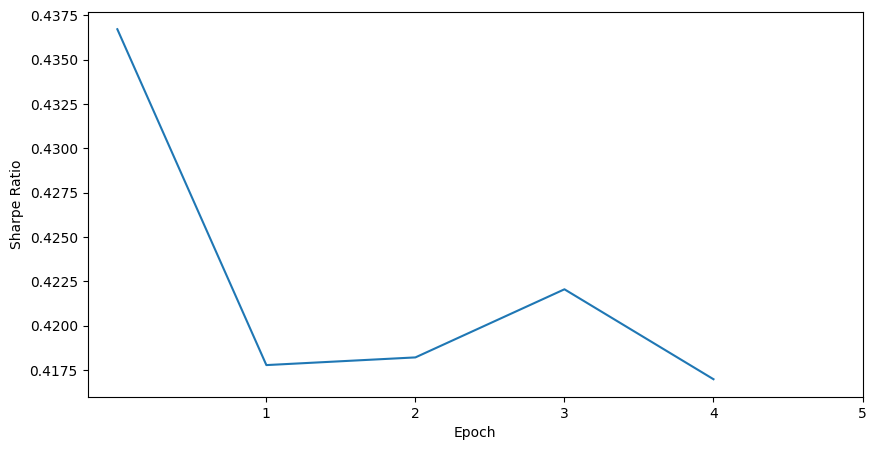

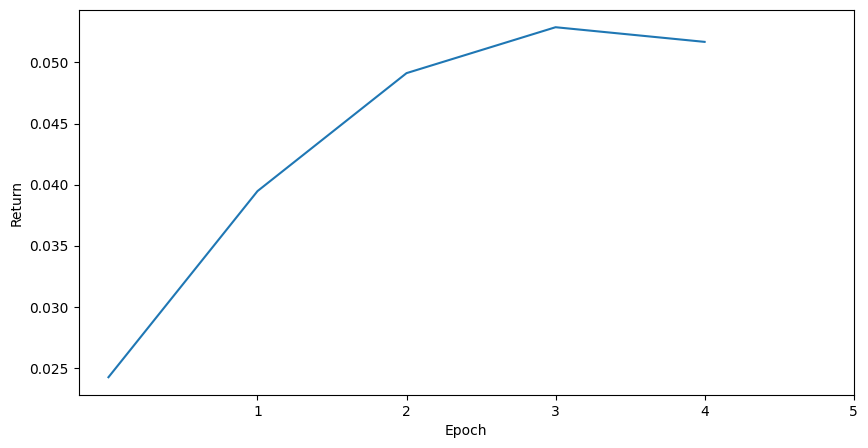

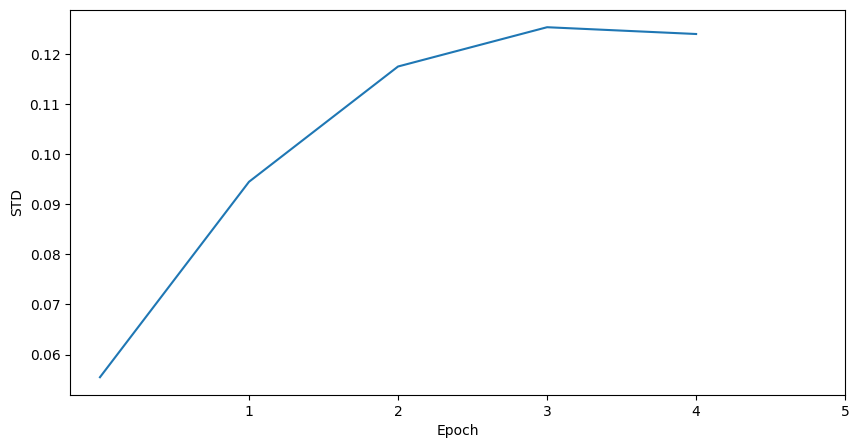

In [13]:
plt.figure(figsize=(10,5))
plt.plot(np.array(test_return) / np.array(test_std), label="test")
plt.xticks(np.arange(1, EPOCHS+1, 1))
plt.ylabel("Sharpe Ratio")
plt.xlabel("Epoch")
plt.show()

plt.figure(figsize=(10,5))
plt.plot(test_return, label="test")
plt.xticks(np.arange(1, EPOCHS+1, 1))
plt.ylabel("Return")
plt.xlabel("Epoch")
plt.show()

plt.figure(figsize=(10,5))
plt.plot(test_std, label="test")
plt.xticks(np.arange(1, EPOCHS+1, 1))
plt.ylabel("STD")
plt.xlabel("Epoch")
plt.show()